In [1]:
import numpy as np
from numpy.linalg import norm
from scipy.linalg import expm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib widget

In [2]:
from qutip.solver.dysolve_propagator import DysolvePropagator, dysolve_propagator
from qutip import Qobj

In [3]:
w01 = 2 * np.pi * 5e3
alpha = -350 * 2 * np.pi
nth = 0
gamma1 = 2 * np.pi * 1
gamma_phi = 2 * np.pi * 0.2
kappa = 0
Omegap = 2 * np.pi * 10
Omegas = 2 * np.pi * 0
wp = w01
ws = w01 * 2
g=0

In [4]:
def annihilation_operator(dim: int) -> np.ndarray:
    a = np.zeros((dim, dim), dtype=complex)
    for n in range(1, dim):
        a[n-1, n] = np.sqrt(n)  # <n-1| a |n> = sqrt(n)
    return a

In [5]:
dimq = 3
dimr = 1

Iq = np.eye(dimq)
Ir = np.eye(dimr)
I = np.kron(Iq, Ir)

a_q = annihilation_operator(dimq)
a = np.kron(a_q, Ir)
a_dag = np.kron(a_q.conj().T, Ir)
a_drive = a + a_dag

b_r = annihilation_operator(dimr)
b = np.kron(Iq, b_r)
b_dag = np.kron(Iq, b_r.conj().T)
b_drive = b + b_dag

In [6]:
H0_q = Qobj(w01 * a_dag @ a + (alpha / 2) * a_dag @ a @ (a_dag @ a - I))
X = Qobj(Omegap * a_drive)

In [7]:
def H_0(w01: float, alpha: float, wr: float, g:float) -> np.ndarray:
    Hq = w01 * a_dag @ a + (alpha / 2) * a_dag @ a @ (a_dag @ a - I)
    Hr = wr * b_dag @ b
    Hint = g * (a_dag + a) @ (b_dag + b)
    return Hq + Hr + Hint

In [8]:
H0 = H_0(w01, alpha, 0, g)

In [9]:
L_list = [np.sqrt(gamma1 * (1 + nth)) * a, np.sqrt(gamma1 * nth) * a_dag,
          np.sqrt(kappa * (1 + nth)) * b, np.sqrt(kappa * nth) * b_dag, np.sqrt(gamma_phi) * a_dag @ a]
L_norm = [L.conj().T @ L for L in L_list]

In [10]:
J = np.zeros((dimq * dimr, dimq * dimr), dtype=complex)
for L in L_list:
    J += L.conj().T @ L

In [11]:
def H_full(t: float) -> np.ndarray:
    H_drive = Omegap * np.cos(wp * t) * a_drive + Omegas * np.cos(ws * t) * b_drive
    return H0 + H_drive - (1j / 2) * J

In [12]:
He = H0 - 1j / 2 * J

In [13]:
time = np.linspace(0, 1, 100000)

In [14]:
dt = time[1] - time[0]

In [15]:
psi_q = np.zeros(dimq, dtype=complex)
psi_q[0] = 1.0
psi_r = np.zeros(dimr, dtype=complex)
psi_r[0] = 1.0

psi0 = np.kron(psi_q, psi_r)


In [58]:
num_trajectories = 100
psi_avg = np.zeros((len(time), dimq * dimr), dtype=complex)

In [59]:
dy = DysolvePropagator(H_0=H0_q, X=X, omega=wp, options={'max_order': 5})

In [ ]:
for _ in tqdm(range(num_trajectories)):
    psis = np.zeros((len(time), dimq * dimr), dtype=complex)
    psis[0] = psi0
    pl = np.zeros(len(L_list)+1, dtype=float)
    cs = np.zeros(len(time), dtype=int)
    for idx, t in enumerate(time[1:], start=1):
        # pump = (np.sin(wp * t) - np.sin(wp * time[idx-1])) * Omegap / wp
        # signal = (np.sin(ws * t) - np.sin(ws * time[idx-1])) * Omegas / ws
        # U = expm(-1j * (He * dt + pump * a_drive + signal * b_drive ))
        U = dy(t, time[idx-1]).full()
        psi = U @ psis[idx-1]
        L0 = I - 1j * H_full(t) * dt
        L0n = L0.conj().T @ L0
        pl[0] = np.real(np.vdot(psi, L0n @ psi)) 
        # pl[0] = 0
        for i, Ln in enumerate(L_norm, start=1):
            pl[i] = np.real(np.vdot(psi, Ln @ psi)) * dt
        pl_sum = np.sum(pl)
        if pl_sum <= 0.0:
            print("Warning: non-positive probability sum")
            break
        pl /= pl_sum
        c = np.random.choice(len(pl), p=pl)
        cs[idx] = c
        if c == 0:
            pass
        else:
            psi = L_list[c-1] @ psi
        psi_norm = norm(psi)
        if psi_norm <= 0:
            print("Warning: zero norm state")
            break
        psis[idx] = psi / psi_norm
    psi_avg+= psis / num_trajectories

  0%|          | 0/100 [00:00<?, ?it/s]

In [52]:
psi_avg[0]

array([2.+0.j, 0.+0.j, 0.+0.j])

In [53]:
a_mean = np.zeros(len(time), dtype=complex)
n_mean = np.zeros(len(time), dtype=complex)
for idx, psi in enumerate(psi_avg):
    a_mean[idx] = np.vdot(psi, a @ psi)
    n_mean[idx] = np.vdot(psi, a_dag @ a @ psi)

In [54]:
pr0 = [np.vdot(psi_avg[i], psi0) for i in range(len(time))]

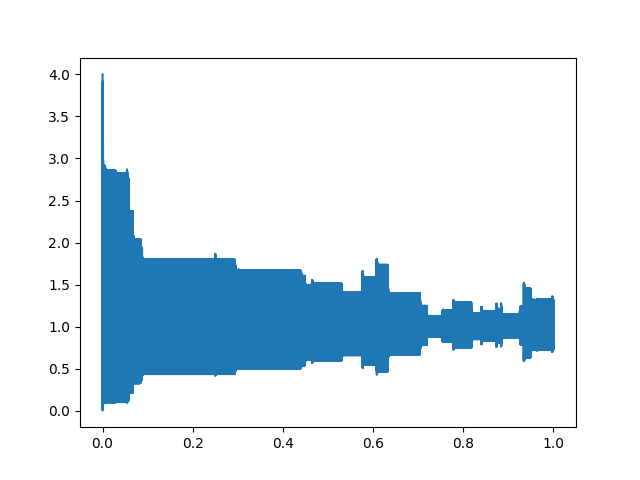

In [55]:
plt.figure()
plt.plot(time, np.abs(pr0)**2)

In [56]:
exp = np.exp(1j * w01 * time)

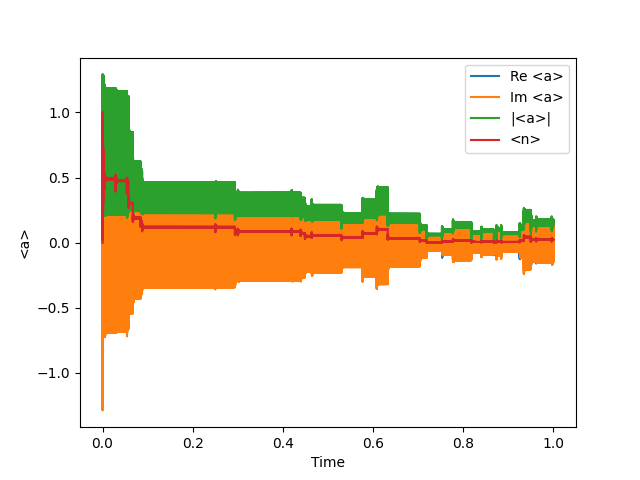

In [57]:
plt.figure()
plt.plot(time, np.real(a_mean * exp), label='Re <a>')
plt.plot(time, np.imag(a_mean*exp), label='Im <a>')
plt.plot(time, np.abs(a_mean*exp), label='|<a>|')
plt.plot(time, np.real(n_mean), label='<n>')
plt.xlabel('Time')
plt.ylabel('<a>')
plt.legend()
plt.show()


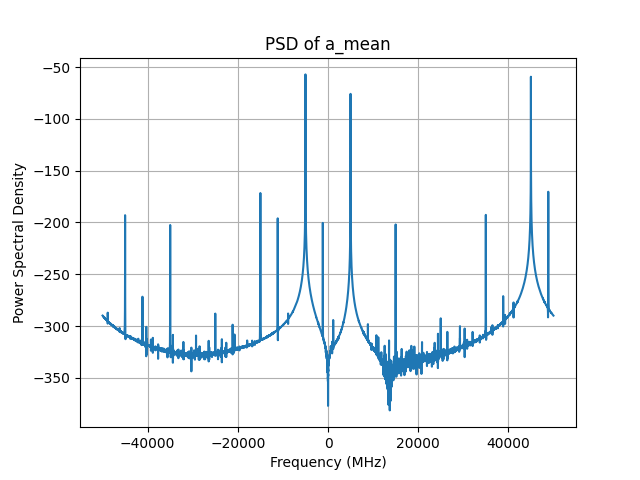

In [48]:
fft_values = np.fft.fftshift(np.fft.fft(a_mean))
psd = np.abs(fft_values)**2
frequencies = np.fft.fftshift(np.fft.fftfreq(len(a_mean), dt))
plt.figure()
plt.magnitude_spectrum(a_mean, Fs=1/dt, scale='dB')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Spectral Density')
plt.title('PSD of a_mean')
plt.grid(True)
plt.show()

/var/folders/t2/sld5kmks7y941_q7f25hz6f00000gn/T/ipykernel_59555/999246536.py:4: UserWarning: nperseg=409600 is greater than signal length max(len(x), len(y)) = 100000, using nperseg = 100000
  frequencies_welch, psd_welch = signal.welch(a_mean, fs=1/dt, nperseg=409600)


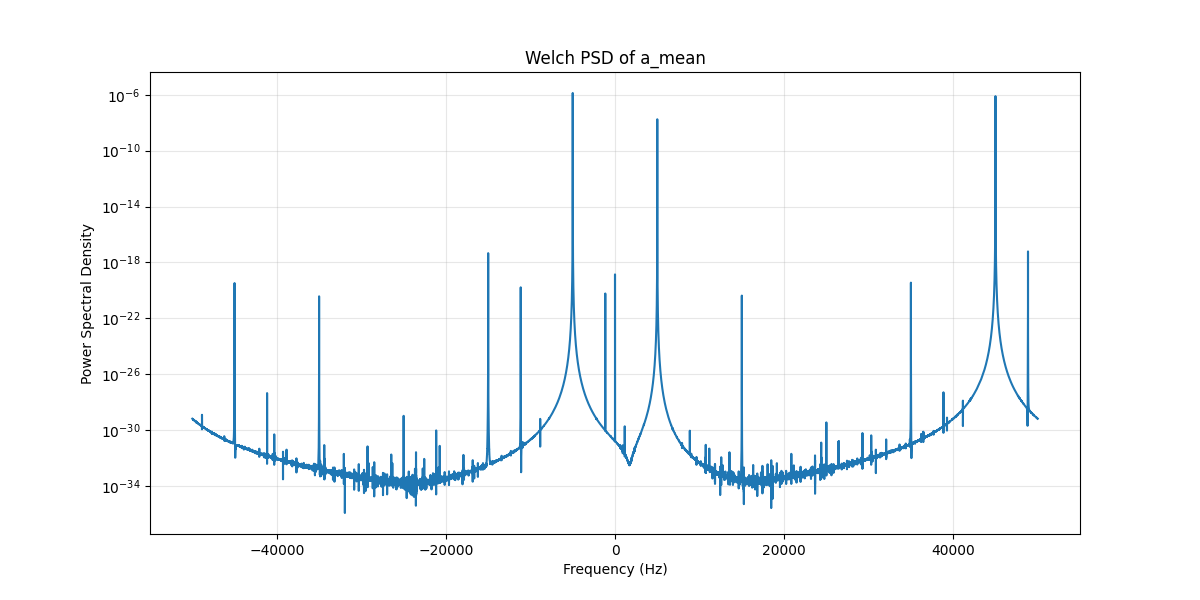

In [49]:
from scipy import signal

# Compute Welch power spectral density
frequencies_welch, psd_welch = signal.welch(a_mean, fs=1/dt, nperseg=409600)
fft_values_welch = np.fft.fftshift(frequencies_welch)
psd_welch_shifted = np.fft.fftshift(psd_welch)

# Plot Welch PSD
plt.figure(figsize=(12, 6))
plt.semilogy(fft_values_welch, psd_welch_shifted)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Welch PSD of a_mean')
plt.grid(True, which='both', alpha=0.3)
plt.show()